In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# Load the dataset
df = pd.read_csv('raw_debt_risk_dataset.csv')

In [30]:
print(df.head())

   Age  Gender           Race Education Level    Industry  \
0   28    Male  Black African      Bachelor's          IT   
1   25    Male  Black African     High School          IT   
2   34  Female  Black African      Bachelor's   Education   
3   32    Male  Black African         Diploma   Education   
4   29  Female  Black African     High School  Healthcare   

   Weekly Hours Worked  Salary (ZAR)  Rent (ZAR)  Transport (ZAR)  \
0                   40         33849    13486.41          3876.51   
1                   45         14784     4848.72          1950.67   
2                   45         22210     6777.67          2278.98   
3                   40         12505     4847.14          1619.73   
4                   30         19688     6123.94          2068.30   

   Groceries (ZAR)  Debt Repayment (ZAR)  Savings (ZAR)  Entertainment (ZAR)  \
0          6558.71              10528.13        2984.29              5747.36   
1          2421.23               5176.99        1704.95   

In [31]:
# Feature Engineering
df['Log_Salary'] = np.log1p(df['Salary (ZAR)'])  
df['Log_Total_Expenses'] = np.log1p(df['Total Expenses (ZAR)'])

In [32]:
# Ratio-Based Features
df['Expense_to_Salary_Ratio'] = df['Total Expenses (ZAR)'] / df['Salary (ZAR)']
df['Savings_to_Salary_Ratio'] = df['Savings (ZAR)'] / df['Salary (ZAR)']
df['Debt_to_Salary_Ratio'] = df['Debt Repayment (ZAR)'] / df['Salary (ZAR)']

In [33]:
# Binning
df['Salary_Bin'] = pd.cut(df['Salary (ZAR)'], bins=[0, 10000, 25000, 50000, np.inf], 
                          labels=['Low', 'Moderate', 'High', 'Very High'])
df['Expenses_Bin'] = pd.cut(df['Total Expenses (ZAR)'], bins=[0, 10000, 25000, 50000, np.inf], 
                            labels=['Low', 'Moderate', 'High', 'Very High'])

In [34]:
# Interaction Features
df['Salary_DTI_Interaction'] = df['Salary (ZAR)'] * df['Debt-to-Income Ratio (%)']

In [35]:
print(df.head())

   Age  Gender           Race Education Level    Industry  \
0   28    Male  Black African      Bachelor's          IT   
1   25    Male  Black African     High School          IT   
2   34  Female  Black African      Bachelor's   Education   
3   32    Male  Black African         Diploma   Education   
4   29  Female  Black African     High School  Healthcare   

   Weekly Hours Worked  Salary (ZAR)  Rent (ZAR)  Transport (ZAR)  \
0                   40         33849    13486.41          3876.51   
1                   45         14784     4848.72          1950.67   
2                   45         22210     6777.67          2278.98   
3                   40         12505     4847.14          1619.73   
4                   30         19688     6123.94          2068.30   

   Groceries (ZAR)  ...  Debt-to-Income Ratio (%)  Debt Risk Level  \
0          6558.71  ...                     31.10        High Risk   
1          2421.23  ...                     35.02        High Risk   
2       

In [36]:
# Step 1: Feature selection (removing columns that strongly correlate with the target)
label_related_features = ['Salary (ZAR)', 'Total Expenses (ZAR)', 'Debt-to-Income Ratio (%)']
df = df.drop(columns=label_related_features)

In [37]:
X = df.drop(columns=['Debt Risk Level'])  # Features (without the target)
y = df['Debt Risk Level']  # Target 

In [38]:
# Distinctly Identify categorical columns
categorical_cols = ['Gender', 'Race', 'Education Level', 'Industry', 'Salary_Bin', 'Expenses_Bin']

In [39]:
# One-hot encode the categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)  # drop_first avoids multicollinearity

In [40]:
print(X_encoded.head())

   Age  Weekly Hours Worked  Rent (ZAR)  Transport (ZAR)  Groceries (ZAR)  \
0   28                   40    13486.41          3876.51          6558.71   
1   25                   45     4848.72          1950.67          2421.23   
2   34                   45     6777.67          2278.98          3785.34   
3   32                   40     4847.14          1619.73          2006.83   
4   29                   30     6123.94          2068.30          3001.48   

   Debt Repayment (ZAR)  Savings (ZAR)  Entertainment (ZAR)  Log_Salary  \
0              10528.13        2984.29              5747.36   10.429694   
1               5176.99        1704.95              2677.12    9.601368   
2               7310.35        4045.64              3630.95   10.008343   
3               3731.77        2178.79              2310.46    9.433964   
4               9716.86        4445.83              3509.54    9.887815   

   Log_Total_Expenses  ...  Industry_Healthcare  Industry_IT  Industry_Mining  \
0    

In [41]:
# Convert boolean columns to 1/0
X_encoded = X_encoded.astype(int)

# Check the first few rows to verify change
print(X_encoded.head())


   Age  Weekly Hours Worked  Rent (ZAR)  Transport (ZAR)  Groceries (ZAR)  \
0   28                   40       13486             3876             6558   
1   25                   45        4848             1950             2421   
2   34                   45        6777             2278             3785   
3   32                   40        4847             1619             2006   
4   29                   30        6123             2068             3001   

   Debt Repayment (ZAR)  Savings (ZAR)  Entertainment (ZAR)  Log_Salary  \
0                 10528           2984                 5747          10   
1                  5176           1704                 2677           9   
2                  7310           4045                 3630          10   
3                  3731           2178                 2310           9   
4                  9716           4445                 3509           9   

   Log_Total_Expenses  ...  Industry_Healthcare  Industry_IT  Industry_Mining  \
0    

In [42]:
#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the model with regularization parameters
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)

# Apply cross-validation on the training data
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {np.mean(cv_scores):.4f}")

# Train the model on the full training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Cross-validation accuracy: 0.8410
Test Accuracy: 0.8490


In [43]:
feature_importances = clf.feature_importances_
feature_names = X_encoded.columns  
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                        Feature  Importance
13       Salary_DTI_Interaction    0.248569
5          Debt Repayment (ZAR)    0.222275
10      Expense_to_Salary_Ratio    0.179599
4               Groceries (ZAR)    0.059817
2                    Rent (ZAR)    0.058995
7           Entertainment (ZAR)    0.056027
3               Transport (ZAR)    0.046983
6                 Savings (ZAR)    0.022568
8                    Log_Salary    0.019658
28          Salary_Bin_Moderate    0.014019
9            Log_Total_Expenses    0.011930
0                           Age    0.008617
31        Expenses_Bin_Moderate    0.007650
29              Salary_Bin_High    0.006116
1           Weekly Hours Worked    0.005021
32            Expenses_Bin_High    0.004928
33       Expenses_Bin_Very High    0.002517
14                  Gender_Male    0.002396
26              Industry_Mining    0.002203
19  Education Level_High School    0.002075
27              Industry_Retail    0.001883
25                  Industry_IT 

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Predicting the values using the model
y_pred = clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Precision, Recall, and F1-Score for each class (binary or multiclass)
precision = precision_score(y_test, y_pred, average='weighted')  # weighted for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Confusion Matrix:
[[788  22   0  10   0]
 [158  82   0  33   0]
 [  0   0 142  46  15]
 [  3   3   0 332   0]
 [  0   0  11   1 354]]
Precision: 0.8478
Recall: 0.8490
F1-Score: 0.8291


In [45]:
# Generating predictions and probabilities
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
                precision    recall  f1-score   support

Critical Risk       0.83      0.96      0.89       820
    High Risk       0.77      0.30      0.43       273
     Low Risk       0.93      0.70      0.80       203
Moderate Risk       0.79      0.98      0.87       338
Very Low Risk       0.96      0.97      0.96       366

     accuracy                           0.85      2000
    macro avg       0.85      0.78      0.79      2000
 weighted avg       0.85      0.85      0.83      2000



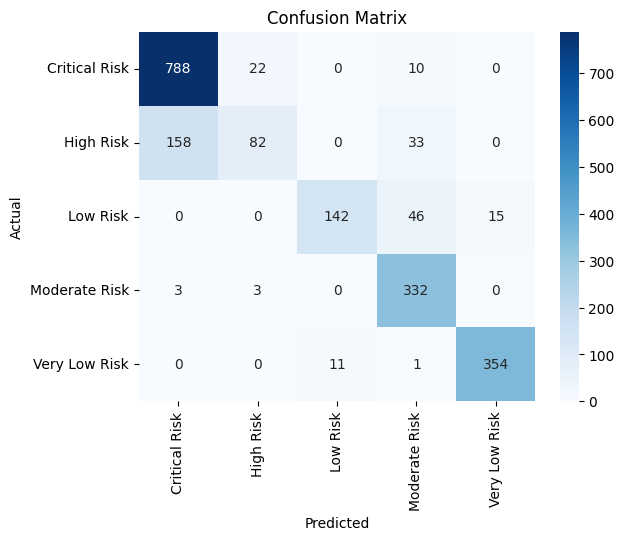

In [46]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

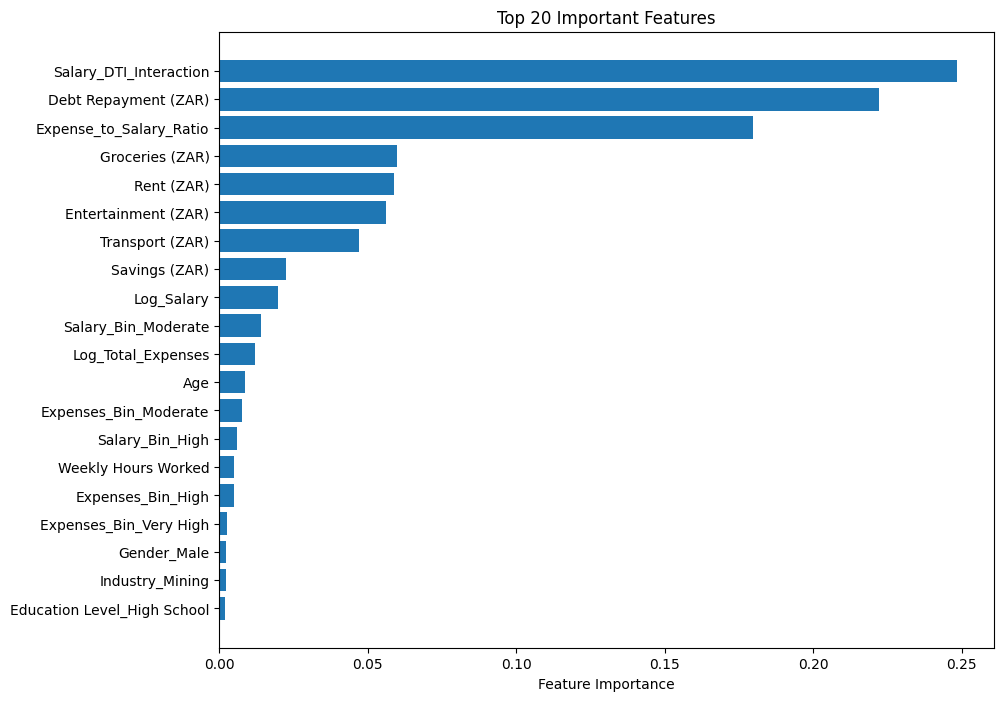

In [47]:
# feature importances
importances = clf.feature_importances_
feature_names = X_encoded.columns
indices = np.argsort(importances)[-20:]  # Top 20 features

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features')
plt.show()